In this notebook we evaluate the fitted OCV results

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch import autograd
import torch.optim as optim
import os
import pandas as pd
import matplotlib.pyplot as plt
from diffthermo.utils import _convert_LFP_data_to_dsdx
from diffthermo.utils_PDOS import read_OCV_data, _get_phase_boundaries
from diffthermo.energy import _H_vib_PDOS_quaderature_model, _PDOS_evaluator, calculate_S_config_total, calculate_S_vib_total_PDOS, solve_Theta_max
from diffthermo.energy import GibbsFE_PDOS as GibbsFE

Import data and parameter settings

In [2]:
# read-in Cp data
# read cp experimental data of LiC6
# read-in data
T_LFP_measured = [180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 298.15, 300, 300, 340, 360, 380, 400]
Cp_LFP_measured = [88.56, 92.44, 96.11, 99.57, 102.8, 105.9, 108.7, 111.4, 113.9, 116.3, 118.4, 120.5, 122.1, 122.4, 129.0, 133.4, 137.6, 141.6, 145.3]
T_LFP_measured = np.array(T_LFP_measured)
Cp_LFP_measured = np.array(Cp_LFP_measured)/7 # this is for 1 mole of LiFePO4, totaling 6 moles of atoms

T_FP_measured = [50.221, 53.703, 59.643, 66.276, 73.591, 81.694, 90.719, 100.73, 110.86, 120.94, 
           131.04, 141.13, 151.25, 161.40, 171.44, 181.60, 191.71, 201.83, 211.94, 222.06, 
           232.15, 242.24, 252.28, 262.36, 272.53, 282.61, 292.62, 302.73]
Cp_FP_measured = [22.153, 23.847, 26.605, 29.555, 32.724, 36.295, 40.161, 44.094, 47.981, 51.730, 
           55.469, 58.974, 62.313, 65.707, 68.868, 71.845, 74.758, 77.690, 80.421, 83.120, 
           85.843, 88.094, 90.685, 92.914, 95.971, 99.141, 101.41, 102.84]
T_FP_measured = np.array(T_FP_measured)
Cp_FP_measured = np.array(Cp_FP_measured)/6 # this is for 1 mole of FePO4, totaling 6 moles of atoms
# only fit to those >200K
T_FP_measured = T_FP_measured[17:]
Cp_FP_measured = Cp_FP_measured[17:]

# convert data
Ts_measured_LFP = torch.from_numpy(T_LFP_measured)
Cps_measured_LFP = torch.from_numpy(Cp_LFP_measured)
Ts_measured_FP = torch.from_numpy(T_FP_measured)
Cps_measured_FP = torch.from_numpy(Cp_FP_measured)



# global settings
quaderature_points = 10
style = "Legendre"


Import experimental measured dsdx data of LFP vs x

In [3]:
x_measured_dsdx, dsdx_measured = _convert_LFP_data_to_dsdx(datafile_name="LFP_dSdx.csv", T=300)

Import experimental measured OCV data of LFP vs x

In [4]:
x1, mu1 = read_OCV_data('LFP_OCV.csv')
T1 = 300

Import fitted PDOS params of fitted LixHM

In [5]:
# Epoch 273  Loss 8.0211  OCV1 2.1527  OCV2 0.0000  OCV3 0.0000  loss_entropy 0.0000 (dSdx_col 0.0000) Cp_HM 0.0000 Cp_LiHM 0.0000 PD 0.0059    
# Omega0 28048.3926 Omega1 -16484.2793 Omega2 -89682.5078 G0 -327753.7188 
# omega0 -0.33438492 omega1 0.39717939 omega2 -0.27892765 
# g00 1.28419614 g01 0.32471576 
# g10 -0.39149332 g11 -0.72280210 
# g20 -0.08793297 g21 -0.26505479 
# g30 0.57227474 g31 0.22373232       
      
      
# initialize g_i_list 
g_ij_list_LixHM = [[1.28419614 , 0.32471576],
                   [ -0.39149332 , -0.72280210 ],
                   [ -0.08793297 , -0.26505479 ],
                   [ 0.57227474 , 0.22373232]]
for i in range(0, len(g_ij_list_LixHM)):
    for j in range(0, len(g_ij_list_LixHM[0])):
        g_ij_list_LixHM[i][j] = nn.Parameter( torch.from_numpy(np.array([g_ij_list_LixHM[i][j]],dtype="float32")) )



Import Hmix parameters (Omegas and G0)

In [6]:
Omega_G0_list = [ 28048.3926 , -16484.2793 , -89682.5078 , -327753.7188   ]

Import Smix parameters (omegas)

In [7]:
S_config_params_list  = [-0.33438492 , 0.39717939 , -0.27892765 ]

Import fitted PDOS params for Li, HM and LiHM

In [8]:
n_list = [9999.9, 6.0, 1.0]
g_i_list_Li = [2.20836568 , 0.58406430 , 1.28776312 , -0.53589582 ] # pretrained via fit_pure_substance_Cp
g_i_list_HM = [1.09458423 , 0.01645601 , -0.09219182 , 0.52285743 ] # pretrained via fit_pure_substance_Cp
g_i_list_LiHM = [1.46579933 , -0.73977888 , 0.19047593 , 0.38283461  ]
# convert pretrained value into torch.tensor
g_i_list_Li = torch.tensor(g_i_list_Li) 
g_i_list_HM = torch.tensor(g_i_list_HM)
g_i_list_LiHM = torch.tensor(g_i_list_LiHM) 
Theta_max_Li = solve_Theta_max(g_i_list = g_i_list_Li, is_x_dependent = False, style = style)
Theta_max_Li = Theta_max_Li.detach()
Theta_max_HM = solve_Theta_max(g_i_list = g_i_list_HM, is_x_dependent = False, style = style)
Theta_max_HM = Theta_max_HM.detach()
Theta_max_LiHM = solve_Theta_max(g_i_list = g_i_list_LiHM, is_x_dependent = False, style = style)
Theta_max_LiHM = Theta_max_LiHM.detach()


In [9]:
## define a total params list for GibbsFE function as input
total_params_list = [Omega_G0_list, S_config_params_list, n_list, g_ij_list_LixHM, g_i_list_HM, g_i_list_Li, Theta_max_HM, Theta_max_Li]

## Visulize fitted PDOS

First visualize the fitted PDOS of FP

Text(0, 0.5, 'PDOS')

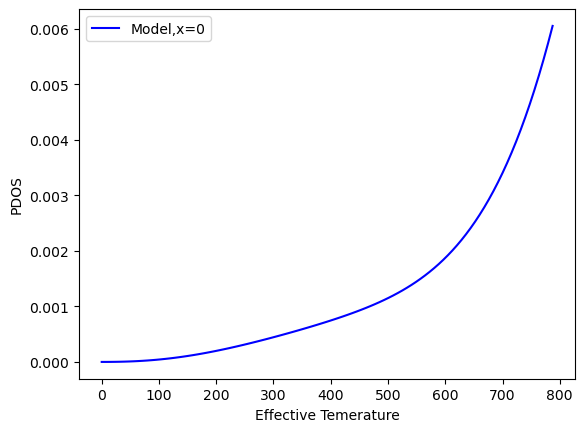

In [10]:

## make sure PDOS is positive everywhere
Theta_max = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = torch.tensor([0.0]), style = style)
Theta_list = torch.from_numpy(np.linspace(0,Theta_max.detach().numpy()[0],100).astype("float32"))
g_omega_list = torch.zeros(len(Theta_list))
for i in range(0, len(Theta_list)):
    Theta_now = Theta_list[i]
    g_omega_now = _PDOS_evaluator(Theta_now, g_ij_matrix = g_ij_list_LixHM, Theta_max = Theta_max, is_x_dependent = True, x = torch.tensor([0.0]), style = "Legendre")
    g_omega_list[i] = 10**-2 * (Theta_now/Theta_max)**2 *g_omega_now

g_omega_list = g_omega_list.detach().numpy()
Theta_list = Theta_list.numpy()
integral = np.trapz(g_omega_list, Theta_list) 
g_omega_list = g_omega_list/integral
plt.plot(Theta_list, g_omega_list, "b-", label='Model,x=0')
plt.legend()
plt.xlabel("Effective Temerature")
plt.ylabel("PDOS")


Then visualize modeled PDOS of LFP. Unfortunately there is no measured PDOS of LFP

Text(0, 0.5, 'PDOS')

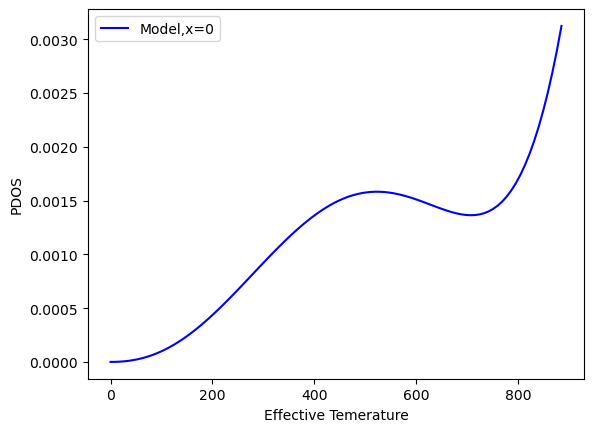

In [11]:

## make sure PDOS is positive everywhere
Theta_max = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = torch.tensor([1.0]), style = style)
Theta_list = torch.from_numpy(np.linspace(0,Theta_max.detach().numpy()[0],100).astype("float32"))
g_omega_list = torch.zeros(len(Theta_list))
for i in range(0, len(Theta_list)):
    Theta_now = Theta_list[i]
    g_omega_now = _PDOS_evaluator(Theta_now, g_ij_matrix = g_ij_list_LixHM, Theta_max = Theta_max, is_x_dependent = True, x = torch.tensor([1.0]), style = "Legendre")
    g_omega_list[i] = 10**-2 * (Theta_now/Theta_max)**2 *g_omega_now

g_omega_list = g_omega_list.detach().numpy()
Theta_list = Theta_list.numpy()
integral = np.trapz(g_omega_list, Theta_list) 
g_omega_list = g_omega_list/integral
plt.plot(Theta_list, g_omega_list, "b-", label='Model,x=0')
plt.legend()
plt.xlabel("Effective Temerature")
plt.ylabel("PDOS")


## Show fitted C_p

First show fitted Cp of FP

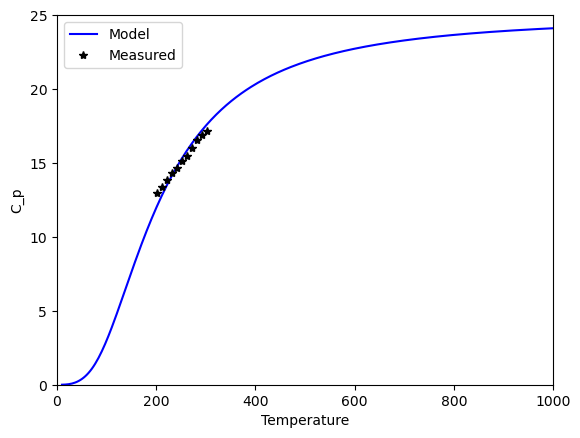

MAE of FP Cp 0.3655 J/mol.K


In [12]:
# convert data
T_maximum_plot = 1000
Ts_calculated = torch.from_numpy(np.linspace(0.,T_maximum_plot,300).astype("float32"))
Cps_calculated = []
Theta_max = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = torch.tensor([0.0]), style = style)
Theta_max = Theta_max.detach()
for i in range(0, len(Ts_calculated)):
    T_now = Ts_calculated[i]
    T_now = T_now.requires_grad_()
    H_vib_now = _H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, Theta_max = Theta_max, quaderature_points=quaderature_points, is_x_dependent = True, x = torch.tensor([0.0]), T = T_now, style = "Legendre")
    Cp_calculated_now = autograd.grad(outputs=H_vib_now, inputs=T_now, create_graph=True)[0]
    Cp_calculated_now = Cp_calculated_now.detach().numpy().tolist()
    Cps_calculated.append(Cp_calculated_now)
Cps_calculated = np.array(Cps_calculated)
Ts_calculated = Ts_calculated.numpy()
# plot figure
plt.plot(Ts_calculated, Cps_calculated, "b-", label='Model')
plt.plot(Ts_measured_FP, Cps_measured_FP, 'k*', label = 'Measured')
plt.legend()
plt.xlabel("Temperature")
plt.ylabel("C_p")
plt.xlim([0,T_maximum_plot])
plt.ylim([0,25])
plt.show()


# calculate error
Cps_calculated = []
for i in range(0, len(Ts_measured_FP)):
    T_now = Ts_measured_FP[i]
    T_now = T_now.requires_grad_()
    H_vib_now = _H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, Theta_max = Theta_max, quaderature_points=quaderature_points, is_x_dependent = True, x = torch.tensor([0.0]), T = T_now, style = "Legendre")
    Cp_calculated_now = autograd.grad(outputs=H_vib_now, inputs=T_now, create_graph=True)[0]
    Cp_calculated_now = Cp_calculated_now.detach().numpy().tolist()
    Cps_calculated.append(Cp_calculated_now)
Cps_calculated = np.array(Cps_calculated)
_Cps_measured_FP = Cps_measured_FP.numpy()
error = np.mean(np.abs(_Cps_measured_FP-Cps_calculated)) # get rid of NaN
print("MAE of FP Cp %.4f J/mol.K" %error)

Next we show fitted Cp of LFP

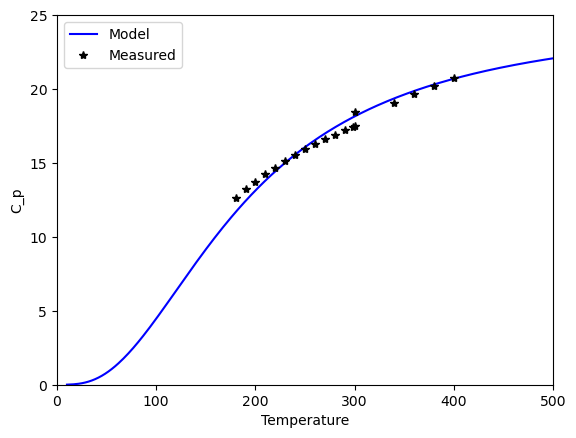

MAE of LFP Cp 0.3839 J/mol.K


In [13]:
# convert data
T_maximum_plot = 500
Ts_calculated = torch.from_numpy(np.linspace(0.,T_maximum_plot,300).astype("float32"))
Cps_calculated = []
Theta_max = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = torch.tensor([1.0]), style = style)
Theta_max = Theta_max.detach()
for i in range(0, len(Ts_calculated)):
    T_now = Ts_calculated[i]
    T_now = T_now.requires_grad_()
    H_vib_now = _H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, Theta_max = Theta_max, quaderature_points=quaderature_points, is_x_dependent = True, x = torch.tensor([1.0]), T = T_now, style = "Legendre")
    Cp_calculated_now = autograd.grad(outputs=H_vib_now, inputs=T_now, create_graph=True)[0]
    Cp_calculated_now = Cp_calculated_now.detach().numpy().tolist()
    Cps_calculated.append(Cp_calculated_now)
Cps_calculated = np.array(Cps_calculated)
Ts_calculated = Ts_calculated.numpy()
# plot figure
plt.plot(Ts_calculated, Cps_calculated, "b-", label='Model')
plt.plot(Ts_measured_LFP, Cps_measured_LFP, 'k*', label = 'Measured')
plt.legend()
plt.xlabel("Temperature")
plt.ylabel("C_p")
plt.xlim([0,T_maximum_plot])
plt.ylim([0,25])
plt.show()

# calculate error
Cps_calculated = []
for i in range(0, len(Ts_measured_LFP)):
    T_now = Ts_measured_LFP[i]
    T_now = T_now.requires_grad_()
    H_vib_now = _H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, Theta_max = Theta_max, quaderature_points=quaderature_points, is_x_dependent = True, x = torch.tensor([1.0]), T = T_now, style = "Legendre")
    Cp_calculated_now = autograd.grad(outputs=H_vib_now, inputs=T_now, create_graph=True)[0]
    Cp_calculated_now = Cp_calculated_now.detach().numpy().tolist()
    Cps_calculated.append(Cp_calculated_now)
Cps_calculated = np.array(Cps_calculated)
_Cps_measured_LFP = Cps_measured_LFP.numpy()
error = np.mean(np.abs(_Cps_measured_LFP-Cps_calculated)) # get rid of NaN
print("MAE of LFP Cp %.4f J/mol.K" %error)

## Show fitted dsdx

In [14]:
x_measured_dsdx, dsdx_measured = _convert_LFP_data_to_dsdx(datafile_name="LFP_dSdx.csv", T=300)


we compare the fitted S_mix with ideal mixing entropy

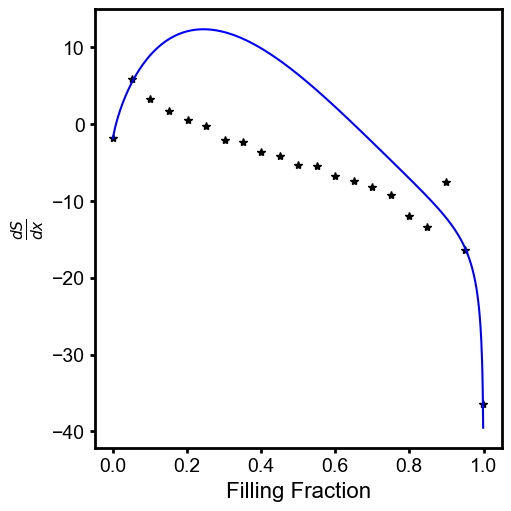

In [15]:
x_calculated = np.linspace(0.001,0.999,1000).astype("float32")
x_calculated = torch.from_numpy(x_calculated)
dsdx_calculated = torch.zeros(len(x_calculated))
s_calculated = torch.zeros(len(x_calculated))
s_ideals = torch.zeros(len(x_calculated))
for i in range(0, len(x_calculated)):
    x = x_calculated[i]
    Theta_max_LixHM = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = x, style = style)
    x = x.requires_grad_()
    s_vib_tot = calculate_S_vib_total_PDOS(x, 300, n_list, g_ij_list_LixHM, g_i_list_HM, g_i_list_Li, Theta_max_LixHM, Theta_max_HM, Theta_max_Li, quaderature_points = quaderature_points, style=style)
    s_config_tot, s_ideal, _ = calculate_S_config_total(x, S_config_params_list, style = style)
    s_ideals[i] = s_ideal
    s_tot = s_vib_tot + s_config_tot 
    s_calculated[i] = s_config_tot
    dsdx_calculated_now = autograd.grad(outputs=s_tot, inputs=x, create_graph=True)[0]
    dsdx_calculated[i] = dsdx_calculated_now

# draw figures 
import matplotlib as mpl  
from matplotlib.ticker import FormatStrFormatter
mpl.rc('font',family='Arial')
fig, ax = plt.subplots(1,1, figsize=(5,5),layout='constrained')
_x = x_measured_dsdx.numpy()
_y = dsdx_measured.numpy()
ax.plot(_x, _y, "k*", label=r'Measured ')
_x1 = x_calculated.numpy()
_y1 = dsdx_calculated.detach().numpy()
ax.plot(_x1, _y1, "b-", label=r'Model')
# ax.legend()
ax.set_xlabel('Filling Fraction', fontsize=16)
ax.set_ylabel(r'$\frac{dS}{dx}$', fontsize=16)
# ax.set_xlim([0,1])
# ax.set_ylim([0,6])
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(width=2)
# plt.savefig("Figure_for_workflow_dsdx.png", dpi=200)


## Show fitted S_mix

we compare the fitted S_mix with ideal mixing entropy

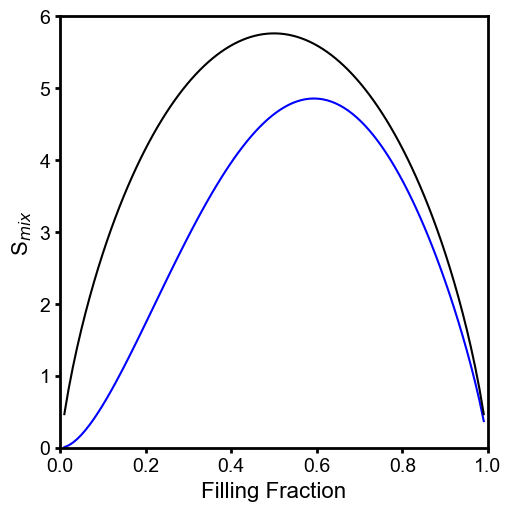

In [16]:
x_calculated = np.linspace(0.01,0.99,100).astype("float32")
x_calculated = torch.from_numpy(x_calculated)
dsdx_calculated = torch.zeros(len(x_calculated))
s_calculated = torch.zeros(len(x_calculated))
s_ideals = torch.zeros(len(x_calculated))
for i in range(0, len(x_calculated)):
    x = x_calculated[i]
    x = x.requires_grad_()
    s_config_tot, s_ideal, _ = calculate_S_config_total(x, S_config_params_list, style = "Legendre")
    s_ideals[i] = s_ideal
    Theta_max_LixHM = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = x, style = style)
    Theta_max_LixHM = Theta_max_LixHM.detach()
    s_vib_tot = calculate_S_vib_total_PDOS(x, 320, n_list, g_ij_list_LixHM, g_i_list_HM, g_i_list_Li, Theta_max_LixHM, Theta_max_HM, Theta_max_Li, quaderature_points = quaderature_points, style=style)
    s_tot = s_config_tot + s_vib_tot
    s_calculated[i] = s_config_tot
    ds_dx = autograd.grad(outputs=s_tot, inputs=x, create_graph=True)[0]
    dsdx_calculated[i] = ds_dx


# draw figures 
import matplotlib as mpl  
from matplotlib.ticker import FormatStrFormatter
mpl.rc('font',family='Arial')
fig, ax = plt.subplots(1,1, figsize=(5,5),layout='constrained')
_x1 = x_calculated.numpy()
_y1 = s_calculated.detach().numpy()
ax.plot(_x1, _y1, "b-", label = 'Model')
_y1 = s_ideals.detach().numpy()
ax.plot(_x1, _y1, "k-", label = 'Ideal')
# ax.legend()
ax.set_xlabel('Filling Fraction', fontsize=16)
ax.set_ylabel(r'S$_{mix}$', fontsize=16)
ax.set_xlim([0,1])
ax.set_ylim([0,6])
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(width=2)
# plt.savefig("Figure_for_workflow_smix.png", dpi=200)

## Evaluate Fitted OCV

In [17]:
# define a helper function
def _calculate_OCV(x_measured, GibbsFE, total_params_list, T, style="Legendre", quaderature_points=5):
    phase_boundary_fixed_point = _get_phase_boundaries(GibbsFE, total_params_list, T, style = style, quaderature_points = quaderature_points, ngrid=99)
    # first predict the one before common tangent
    mu_pred = []
    for i in range(0, len(x_measured)):
        x_now = x_measured[i]
        x_now = x_now.requires_grad_()
        g_now = GibbsFE(x_now, T, total_params_list, style = style, quaderature_points = quaderature_points)
        mu_pred_now = autograd.grad(outputs=g_now, inputs=x_now, create_graph=True)[0]
        mu_pred.append(mu_pred_now.detach().numpy())
    mu_pred = np.array(mu_pred)
    # calculate mu after common tangent construction
    mu_pred_after_ct = []
    # see if x is inside any gaps
    def _is_inside_gaps(_x, _gaps_list):
        _is_inside = False
        _index = -99999
        for i in range(0, len(_gaps_list)):
            if _x >= _gaps_list[i][0] and _x <= _gaps_list[i][1]:
                _is_inside = True
                _index = i
                break
        return _is_inside, _index
    # pred
    for i in range(0, len(x_measured)):
        x_now = x_measured[i]
        is_inside, index = _is_inside_gaps(x_now, phase_boundary_fixed_point)
        if is_inside == False:
            # outside miscibility gap 
            mu_pred_after_ct.append(mu_pred[i])
        else: 
            # inside miscibility gap
            x_alpha = phase_boundary_fixed_point[index][0]
            x_beta = phase_boundary_fixed_point[index][1]
            ct_pred = (GibbsFE(x_alpha, T, total_params_list, style = style, quaderature_points = quaderature_points) - GibbsFE(x_beta, T, total_params_list, style = style, quaderature_points = quaderature_points))/(x_alpha - x_beta) 
            if torch.isnan(ct_pred) == False:
                mu_pred_after_ct.append(ct_pred.clone().detach().numpy()[0]) 
            else:
                mu_pred_after_ct.append(mu_pred[i])
    print(mu_pred_after_ct)
    mu_pred_after_ct = np.array(mu_pred_after_ct)
    U_pred_after_ct = mu_pred_after_ct/(-96485)
    return U_pred_after_ct
    

In [18]:
U1 = _calculate_OCV(x1, GibbsFE, total_params_list, T1)

[-368530.1, -328912.8, -328912.8, -328912.8, -328912.8, -328912.8, -328912.8, -328912.8, -328912.8, -328912.8, -328912.8, -328912.8, -328912.8, -328912.8, -328912.8, -328912.8, -328912.8, -328912.8, -328912.8, -303276.28, -241093.94]


Average MAE is 0.0276 V


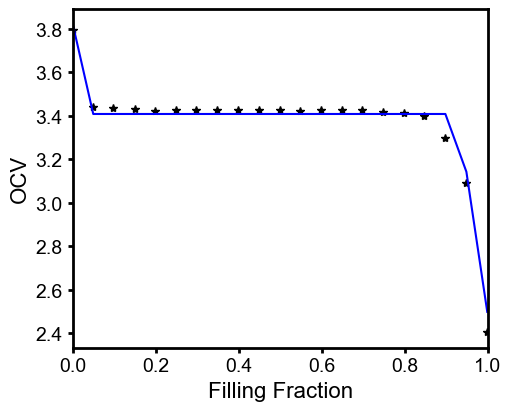

In [19]:
# draw figures 
import matplotlib as mpl  
from matplotlib.ticker import FormatStrFormatter
mpl.rc('font',family='Arial')
fig, ax = plt.subplots(1,1, figsize=(5,4),layout='constrained')
ax.plot(x1.numpy(), mu1.numpy()/-96485, "k*", label=r'Measured')
ax.plot(x1.numpy(), U1, "b-", label=r'Model')
# ax.legend()
ax.set_xlabel('Filling Fraction', fontsize=16)
ax.set_ylabel('OCV', fontsize=16)
ax.set_xlim([0,1])
# ax.set_ylim([3.2,3.6])
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(width=2)
# plt.savefig("Figure_for_workflow_OCV.png", dpi=200)

# plt.plot(x1.numpy(), U1, "b-", label=r'Model (47$^\circ$C)')
# plt.plot(x1.numpy(), mu1.numpy()/-96485, "k*", label=r'Measured (47$^\circ$C)')
# plt.xlabel('Filling Fraction', fontsize=18)
# plt.ylabel('OCV [V]', fontsize=18)
# plt.legend(frameon=False, fontsize=14)
error = np.mean(np.abs(U1-(mu1.numpy()/-96485)))
print("Average MAE is %.4f V" %(error))
# print(np.abs(U1-(mu1.numpy()/-96485))*1000)

# Now, let us plot the figures for publication

Helper functions to plot Fitted OCV at vs experiment and report error, dQdV analysis

In [20]:
# define a helper function
def _calculate_dVdQ(x_measured, GibbsFE, total_params_list, T, style="Legendre", quaderature_points=10):
    phase_boundary_fixed_point = _get_phase_boundaries(GibbsFE, total_params_list, T, style = style, quaderature_points = quaderature_points, ngrid=99)
        # see if x is in any gaps
    def _is_inside_gaps(_x, _gaps_list):
        _is_inside = False
        _index = -99999
        if len(_gaps_list) == 0:
            return False, -99999
        for i in range(0, len(_gaps_list)):
            if _x >= _gaps_list[i][0] and _x <= _gaps_list[i][1]:
                _is_inside = True
                _index = i
                break
        return _is_inside, _index

    OCV_calculated = []
    dOCV_calculated_dx = [] # this is dVdQ, dQdV is 1/dVdQ
    # dOCV_calculated_dT = []
    # d2OCV_calculated_dT_dx = [] # first do dT, then dx
    # d2OCV_calculated_dx_dT = [] # first do dx, then dT
    for i in range(0, len(x_measured)):
        x_now = x_measured[i]
        is_inside, index = _is_inside_gaps(x_now, phase_boundary_fixed_point)
        if is_inside == False:
            # outside miscibility gap 
            x_now = x_now.requires_grad_()
            g_now = GibbsFE(x_now, T, total_params_list, style = style, quaderature_points = quaderature_points)
            mu_pred_now = autograd.grad(outputs=g_now, inputs=x_now, create_graph=True)[0]
            OCV_calculated_now = -mu_pred_now/96485
            OCV_calculated.append(OCV_calculated_now)
            dOCV_calculated_dx_now = autograd.grad(outputs=OCV_calculated_now, inputs=x_now, create_graph=True)[0]
            dOCV_calculated_dx.append(dOCV_calculated_dx_now)
        else: 
            # inside miscibility gap
            x_alpha = phase_boundary_fixed_point[index][0]
            x_beta = phase_boundary_fixed_point[index][1]
            ct_pred = ( GibbsFE(x_alpha, T, total_params_list, style = style, quaderature_points = quaderature_points) - GibbsFE(x_beta, T, total_params_list, style = style, quaderature_points = quaderature_points) )/(x_alpha - x_beta) 
            if torch.isnan(ct_pred):
                print("Common tangent is NaN")
                x_alpha = 99999.9
                x_beta = -99999.9
            if x_alpha > x_beta:
                print("Error in phase equilibrium boundary, x_left %.4f larger than x_right %.4f. If Hessian loss is not 0, it's fine. Otherwise check code carefully!" %(x_alpha, x_beta))
                x_alpha = 99999.9
                x_beta = -99999.9
            if torch.isnan(ct_pred):
                print("Warning: skipped for loss calculation at a filling fraction x")
            else:
                OCV_calculated_now = -ct_pred/96485
                OCV_calculated.append(OCV_calculated_now)
                # dOCV_calculated_dx_now = autograd.grad(outputs=OCV_calculated_now, inputs=x_now, create_graph=True)[0]
                dOCV_calculated_dx.append(torch.tensor(-1e-7))  
    for i in range(0, len(dOCV_calculated_dx)):
        dOCV_calculated_dx[i] = dOCV_calculated_dx[i].detach().numpy().tolist()
    dOCV_calculated_dx = torch.tensor(dOCV_calculated_dx)
    return dOCV_calculated_dx

In [21]:
# calculate dVdQ at 300K from model
# [[0.0438, 0.9252], 300]
_x1 = torch.from_numpy(np.array([0.01,0.02, 0.0,0.035, 0.04, 0.041, 0.042, 0.043,0.0431,0.0432,0.0433,0.0434,0.0435,0.0436,0.0437,0.0439, 0.0441,  0.9251,  0.9252, 0.9253,  0.9254,  0.93,  0.94, 0.95, 0.96]).astype("float32"))
U1_dvdq = _calculate_OCV(_x1, GibbsFE, total_params_list, T1)
dVdQ_1_calculated = _calculate_dVdQ(_x1, GibbsFE, total_params_list, T1, style="Legendre", quaderature_points=5)

[-359448.78, -349857.88, 0.0, -336449.88, -332247.78, -331423.38, -330604.38, -329790.66, -329709.56, -329628.53, -329547.62, -329466.7, -329385.84, -329305.0, -329224.25, -329062.88, -328912.8, -324331.25, -324245.8, -324160.2, -324074.56, -320071.66, -310926.0, -301150.62, -290709.8]


In [22]:
# calculate dVdQ at 300K from experimental measured OCV 
df = pd.read_csv("LFP_OCV.csv",header=None) # deleted those datapoints within miscibility gaps
data = df.to_numpy()
x_300K = data[:,0] # Li filling fraction of graphite, from 0 to 1
OCV_300K = data[:,1] 

dQdV_300K = np.zeros_like(OCV_300K)
dQdV_300K[0] = (x_300K[1]-x_300K[0])/(OCV_300K[1]-OCV_300K[0])
for i in range(1, len(OCV_300K)):
    dQdV_300K[i] = np.abs((x_300K[i]-x_300K[i-1])/(OCV_300K[i]-OCV_300K[i-1]))


Let's plot a figure about how did we do the S_pretrain (with fit_dsdx): (a) Fitted dsdx, (b) fitted s_config vs s_ideal, the Cp of LixHM collapses to (c) C6 and (d) LiC6 at x=0 and 1,   (e) Fitted OCV at 47C vs experiment and report error, (f) dQdV analysis

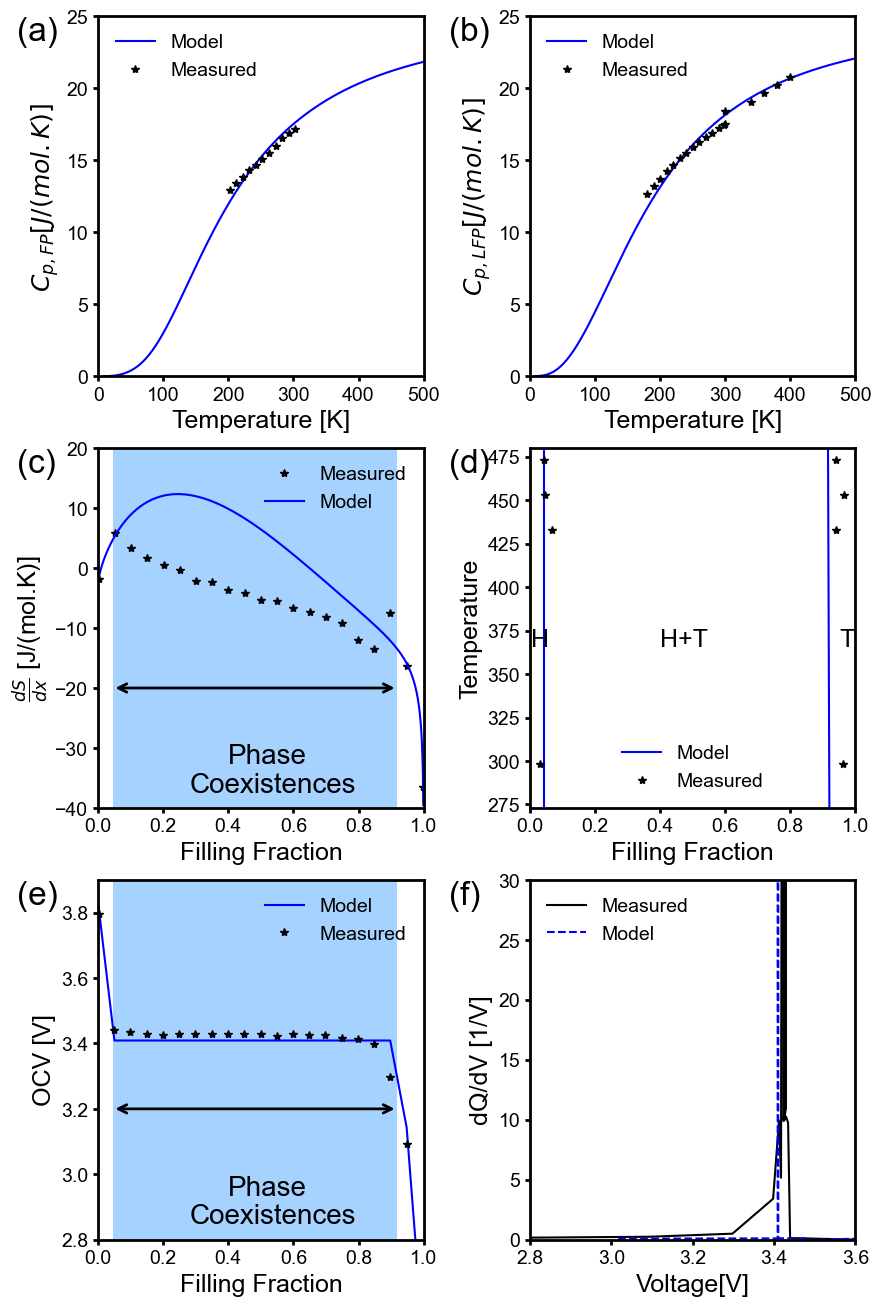

In [52]:
# draw figures 
import matplotlib as mpl  
from matplotlib.ticker import FormatStrFormatter
mpl.rc('font',family='Arial')
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch

# fig, axes = plt.subplots(2,2, figsize=(8.7,8.7),layout='constrained')
fig, axes = plt.subplots(3,2, figsize=(8.7,12.95),layout='constrained')


# Cp of HM
ax_now = axes[0][0]
T_maximum_plot = 500
Ts_calculated = torch.from_numpy(np.linspace(0.,T_maximum_plot,300).astype("float32"))
Cps_calculated = []
Theta_max = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = torch.tensor([0.0]), style = style)
Theta_max = Theta_max.detach()
for i in range(0, len(Ts_calculated)):
    T_now = Ts_calculated[i]
    T_now = T_now.requires_grad_()
    H_vib_now = _H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, Theta_max = Theta_max, quaderature_points=quaderature_points, is_x_dependent = True, x = torch.tensor([0.0]), T = T_now, style = "Legendre")
    Cp_calculated_now = autograd.grad(outputs=H_vib_now, inputs=T_now, create_graph=True)[0]
    Cp_calculated_now = Cp_calculated_now.detach().numpy().tolist()
    Cps_calculated.append(Cp_calculated_now)
Cps_calculated = np.array(Cps_calculated)
Ts_calculated = Ts_calculated.numpy()
# plot figure
ax_now.plot(Ts_calculated, Cps_calculated, "b-", label='Model')
ax_now.plot(Ts_measured_FP, Cps_measured_FP, 'k*', label = 'Measured')
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlabel("Temperature [K]", fontsize=18)
ax_now.set_ylabel("$C_{p, FP} [J/(mol.K)]$", fontsize=18)
ax_now.set_xlim([0,T_maximum_plot])
ax_now.set_ylim([0,25])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)
# add label
ax_now.text(
    -0.25, 1, '(a)',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=24,
    fontweight='normal',
    va='top',
    ha='left'
)

## now Cp of LFP
ax_now = axes[0][1]
T_maximum_plot = 500
Ts_calculated = torch.from_numpy(np.linspace(0.,T_maximum_plot,300).astype("float32"))
Cps_calculated = []
Theta_max = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = torch.tensor([1.0]), style = style)
Theta_max = Theta_max.detach()
for i in range(0, len(Ts_calculated)):
    T_now = Ts_calculated[i]
    T_now = T_now.requires_grad_()
    H_vib_now = _H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, Theta_max = Theta_max, quaderature_points=quaderature_points, is_x_dependent = True, x = torch.tensor([1.0]), T = T_now, style = "Legendre")
    Cp_calculated_now = autograd.grad(outputs=H_vib_now, inputs=T_now, create_graph=True)[0]
    Cp_calculated_now = Cp_calculated_now.detach().numpy().tolist()
    Cps_calculated.append(Cp_calculated_now)
Cps_calculated = np.array(Cps_calculated)
Ts_calculated = Ts_calculated.numpy()
# plot figure
ax_now.plot(Ts_calculated, Cps_calculated, "b-", label='Model')
ax_now.plot(Ts_measured_LFP, Cps_measured_LFP, 'k*', label = 'Measured')
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlabel("Temperature [K]", fontsize=18)
ax_now.set_ylabel("$C_{p, LFP} [J/(mol.K)]$", fontsize=18)
ax_now.set_xlim([0,T_maximum_plot])
ax_now.set_ylim([0,25])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)
# add label
ax_now.text(
    -0.25, 1, '(b)',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=24,
    fontweight='normal',
    va='top',
    ha='left'
)


# fitted dsdx
ax_now = axes[1][0]
x_calculated = np.linspace(0.001,0.999,1000).astype("float32")
x_calculated = torch.from_numpy(x_calculated)
dsdx_calculated = torch.zeros(len(x_calculated))
s_calculated = torch.zeros(len(x_calculated))
s_ideals = torch.zeros(len(x_calculated))
for i in range(0, len(x_calculated)):
    x = x_calculated[i]
    Theta_max_LixHM = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = x, style = style)
    x = x.requires_grad_()
    s_vib_tot = calculate_S_vib_total_PDOS(x, 300, n_list, g_ij_list_LixHM, g_i_list_HM, g_i_list_Li, Theta_max_LixHM, Theta_max_HM, Theta_max_Li, quaderature_points = quaderature_points, style=style)
    s_config_tot, s_ideal, _ = calculate_S_config_total(x, S_config_params_list, style = style)
    s_ideals[i] = s_ideal
    s_tot = s_vib_tot + s_config_tot 
    s_calculated[i] = s_config_tot
    dsdx_calculated_now = autograd.grad(outputs=s_tot, inputs=x, create_graph=True)[0]
    dsdx_calculated[i] = dsdx_calculated_now
_x = x_measured_dsdx.numpy()
_y = dsdx_measured.numpy()
ax_now.plot(_x, _y, "k*", label=r'Measured')
_x1 = x_calculated.numpy()
_y1 = dsdx_calculated.detach().numpy()
ax_now.plot(_x1, _y1, "b-", label=r'Model')
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'$\frac{dS}{dx}$ [J/(mol.K)]', fontsize=18)
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([0,1])
ax_now.set_ylim([-40,20])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)

rect = patches.Rectangle(
    (0.0441,  -50),               # bottom left corner (x0, y0)
    0.9196-0.0441,                  # width
    100,                   # height
    linewidth=1,
    edgecolor='none',
    facecolor='#1E90FF',  
    alpha=0.4,  # transparency (0 = fully transparent, 1 = fully opaque)
)
ax_now.add_patch(rect)
# Add bidirectional arrow
start = (0.0441, -20)
end = (0.9196, -20)
arrow = FancyArrowPatch(
    start, end,
    arrowstyle='<->',
    mutation_scale=15,  # size of arrow heads
    color='black',
    linewidth=2
)
ax_now.add_patch(arrow)
# add label
ax_now.text(
    0.4, 0.18, 'Phase',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=20,
    fontweight='normal',
    va='top',
    ha='left'
)
ax_now.text(
    0.28, 0.1, 'Coexistences',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=20,
    fontweight='normal',
    va='top',
    ha='left'
)

# add label
ax_now.text(
    -0.25, 1, '(c)',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=24,
    fontweight='normal',
    va='top',
    ha='left'
)


# pseudo phase diagram??
ax_now = axes[1][1]

phase1 = [[[0.0441, 0.9202], 273],\
[[0.0441, 0.9196], 300],\
[[0.0441, 0.9170], 430],\
[[0.0441, 0.9160], 480]]


x_left_phase_1 = []
x_right_phase_1 = []
T_phase_1 = []
for i in range(0, len(phase1)):
    x_left_phase_1.append(phase1[i][0][0])
    x_right_phase_1.append(phase1[i][0][1])
    T_phase_1.append(phase1[i][1])
x_left_phase_1 = np.array(x_left_phase_1)
x_right_phase_1 = np.array(x_right_phase_1)
T_phase_1 = np.array(T_phase_1)

phase_boundaries_from_phase_diagram = [[25+273.15, [0.029718875502008052, 0.9622489959839359]],
                                       [160+273.15, [0.06666666666666671, 0.9397590361445786]],
                                       [180+273.15, [0.04658634538152612, 0.9638554216867471]],
                                       [200+273.15, [0.04337349397590362, 0.9397590361445786]]]
  
x_left_phase_true = []
x_right_phase_true = []
T_phase_true = []
for i in range(0, len(phase_boundaries_from_phase_diagram)):
    x_left_phase_true.append(phase_boundaries_from_phase_diagram[i][1][0])
    x_right_phase_true.append(phase_boundaries_from_phase_diagram[i][1][1])
    T_phase_true.append(phase_boundaries_from_phase_diagram[i][0])
x_left_phase_true = np.array(x_left_phase_true)
x_right_phase_true = np.array(x_right_phase_true)
T_phase_true = np.array(T_phase_true)

ax_now.plot(x_left_phase_1, T_phase_1, 'b-')
ax_now.plot(x_right_phase_1, T_phase_1, 'b-', label="Model")
ax_now.plot(x_left_phase_true, T_phase_true, 'k*')
ax_now.plot(x_right_phase_true, T_phase_true, 'k*', label = "Measured")
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel('Temperature', fontsize=18)
ax_now.set_ylim([273,480])
ax_now.set_xlim([0,1])
ax_now.legend(frameon=False, fontsize=14)
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)
ax_now.text(
    0.002, 0.5, 'H',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=18,
    fontweight='normal',
    va='top',
    ha='left'
)
ax_now.text(
    0.4, 0.5, 'H+T',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=18,
    fontweight='normal',
    va='top',
    ha='left'
)
ax_now.text(
    0.95, 0.5, 'T',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=18,
    fontweight='normal',
    va='top',
    ha='left'
)
# add label
ax_now.text(
    -0.25, 1, '(d)',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=24,
    fontweight='normal',
    va='top',
    ha='left'
)


# OCV vs experiment 
ax_now = axes[2][0]
ax_now.plot(x1.numpy(), U1, "b-", label=r'Model')
ax_now.plot(x1.numpy(), mu1.numpy()/-96485, "k*", label=r'Measured')
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel('OCV [V]', fontsize=18)
ax_now.set_ylim([2.8,3.9])
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)

rect = patches.Rectangle(
    (0.0441,  -50),               # bottom left corner (x0, y0)
    0.9196-0.0441,                  # width
    100,                   # height
    linewidth=1,
    edgecolor='none',
    facecolor='#1E90FF',  
    alpha=0.4,  # transparency (0 = fully transparent, 1 = fully opaque)
)
ax_now.add_patch(rect)
# Add bidirectional arrow
start = (0.0441, 3.2)
end = (0.9196, 3.2)
arrow = FancyArrowPatch(
    start, end,
    arrowstyle='<->',
    mutation_scale=15,  # size of arrow heads
    color='black',
    linewidth=2
)
ax_now.add_patch(arrow)
# add label
ax_now.text(
    0.4, 0.18, 'Phase',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=20,
    fontweight='normal',
    va='top',
    ha='left'
)
ax_now.text(
    0.28, 0.1, 'Coexistences',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=20,
    fontweight='normal',
    va='top',
    ha='left'
)
# add label
ax_now.text(
    -0.25, 1, '(e)',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=24,
    fontweight='normal',
    va='top',
    ha='left'
)

# dQdV VS experiment
ax_now = axes[2][1]
ax_now.plot(OCV_300K, dQdV_300K, 'k-', label='Measured')
dQdV_plot = -(1/(dVdQ_1_calculated)).numpy()
dQdV_plot[2] = 0.0 # fix -inf issue
U1_dvdq[2] = 3.48706923 # fix 0.0 issue
U1_dvdq[17] = U1_dvdq[16] # fix the double inf line here because delta U is not small enough 
ax_now.plot(U1_dvdq, dQdV_plot, 'b--', label='Model')
ax_now.set_xlabel('Voltage[V]', fontsize=18)
ax_now.set_ylabel('dQ/dV [1/V]', fontsize=18)
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([2.8,3.6])
ax_now.set_ylim([0.0, 30])
# add label
ax_now.text(
    -0.25, 1, '(f)',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=24,
    fontweight='normal',
    va='top', 
    ha='left'
)

plt.savefig("FigureLFP.pdf", format='pdf', bbox_inches='tight')
# plt.savefig("FigureLFP_raw.png", dpi=200)

In [24]:
phase_boundary_fixed_point_273 = _get_phase_boundaries(GibbsFE, total_params_list, 273, style = style, quaderature_points = quaderature_points, ngrid=99)
# phase_boundary_fixed_point_290 = _get_phase_boundaries(GibbsFE, total_params_list, 290, style = style, quaderature_points = quaderature_points, ngrid=99)
phase_boundary_fixed_point_300 = _get_phase_boundaries(GibbsFE, total_params_list, 300, style = style, quaderature_points = quaderature_points, ngrid=99)
phase_boundary_fixed_point_330 = _get_phase_boundaries(GibbsFE, total_params_list, 330, style = style, quaderature_points = quaderature_points, ngrid=99)
phase_boundary_fixed_point_430 = _get_phase_boundaries(GibbsFE, total_params_list, 430, style = style, quaderature_points = quaderature_points, ngrid=99)
# phase_boundary_fixed_point_450 = _get_phase_boundaries(GibbsFE, total_params_list, 450, style = style, quaderature_points = quaderature_points, ngrid=99)
phase_boundary_fixed_point_480 = _get_phase_boundaries(GibbsFE, total_params_list, 480, style = style, quaderature_points = quaderature_points, ngrid=99)


In [56]:
print("%.10f, %.10f" %(phase_boundary_fixed_point_300[0][0], phase_boundary_fixed_point_300[0][1]))

0.0440859497, 0.9196369648


In [26]:
# [[0.0441, 0.9202], 273]
# [[0.0441, 0.9196], 300]
# [[0.0441, 0.9170], 430]
# [[0.0441, 0.9160], 480]